## Import Libraries

### Python Libraries

In [1]:
from datetime import datetime

from torch.optim.lr_scheduler import ReduceLROnPlateau

### External Libraries

In [2]:
import numpy as np
import torch
import torch.nn as nn

### Custom Libraries

In [3]:
from utils_random import set_random_seed
from utils_io import read_bitarrays
from utils_torch.data import stratified_random_split
from utils_attacker_lstm.data import DatasetAttackerLSTMPool, DataLoaderAttackerLSTM
from utils_attacker_lstm.models import ModelAttackerConvLSTMLinear, TrainerAttackerLSTM, TesterAttackerLSTM, \
    ManagerAttackerLSTM
from utils_plot import plot_train_eval_loss_accuracy, plot_receiver_operating_characteristics_curve, \
    plot_confusion_matrix

## Set Parameters

### Model Id

In [4]:
model_id = datetime.now().strftime('%m%d%H%M')

In [5]:
random_seed = 69

### Data Params

In [6]:
num_snps = 80000
train_eval_test_split = [0.7, 0.15, 0.15]

### Loader Params

In [7]:
genome_batch_size = 32
snp_batch_size = 20000

### Model Params

#### Conv1d Params

In [8]:
conv_num_layers = 2
conv_channel_size = [3, 4, 8]
conv_kernel_size = [20, 10]
conv_stride = [2, 1]
conv_dilation = [1, 2]
conv_groups = [1, 1]

conv_activation = [nn.ReLU]
conv_activation_kwargs = [{}]

conv_dropout_p = [0.5]
conv_dropout_first = [True]

conv_batch_norm = [True]
conv_batch_norm_momentum = [0.1]

#### Conv1d to LSTM Params

In [9]:
conv_lstm_activation = nn.ReLU
conv_lstm_activation_kwargs = {}
conv_lstm_dropout_p = 0.25
conv_lstm_dropout_first = True
conv_lstm_layer_norm = True

#### LSTM Params

In [10]:
lstm_num_layers = 1
lstm_input_size = 8
lstm_hidden_size = [16]
lstm_proj_size = [0]
lstm_bidirectional = [True]

lstm_dropout_p = []
lstm_dropout_first = []

lstm_layer_norm = []

#### LSTM to Linear Params

In [11]:
lstm_linear_dropout_p = 0.25
lstm_linear_dropout_first = True

lstm_linear_batch_norm = True
lstm_linear_batch_norm_momentum = 0.1

#### Linear Params

In [12]:
linear_num_layers = 1
linear_num_features = [32, 1]

linear_activation = []
linear_activation_kwargs = []

linear_dropout_p = []
linear_dropout_first = []

linear_batch_norm = []
linear_batch_norm_momentum = []

### Trainer Params

In [13]:
num_epochs = 256
learning_rate = 0.001

### IO Params

In [14]:
models_dir = "../models"
models_file = "models.csv"
plots_dir = "../plots"

## Set Torch Device

In [15]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Set Random Seed

In [16]:
set_random_seed(random_seed)

## Load Data

### Load Genomes

In [17]:
genomes_pool = read_bitarrays('../data/test/In_Pop.pkl')[:, :num_snps]
genomes_reference = read_bitarrays('../data/test/Not_In_Pop.pkl')[:, :num_snps]
genomes = np.concatenate((genomes_pool, genomes_reference), axis=0)

### Load Labels

In [18]:
labels_beacon = np.ones(genomes_pool.shape[0], dtype=bool)
labels_reference = np.zeros(genomes_reference.shape[0], dtype=bool)
labels = np.concatenate((labels_beacon, labels_reference), axis=0).astype(bool)

### Compute Frequencies

In [19]:
frequencies_pool = np.mean(genomes_pool, axis=0)
frequencies_reference = np.mean(genomes_reference, axis=0)

## Create Dataset

In [20]:
dataset = DatasetAttackerLSTMPool(
    target_genomes=genomes,
    pool_frequencies=frequencies_pool,
    reference_frequencies=frequencies_reference,
    targets=labels)
subset_train, subset_eval, subset_test = stratified_random_split(dataset, train_eval_test_split)

## Create DataLoaders

In [21]:
loader_train = DataLoaderAttackerLSTM(subset_train, genome_batch_size, snp_batch_size, shuffle=True)
loader_eval = DataLoaderAttackerLSTM(subset_eval, genome_batch_size, snp_batch_size, shuffle=False)
loader_test = DataLoaderAttackerLSTM(subset_test, genome_batch_size, snp_batch_size, shuffle=False)

## Create Model

In [22]:
model = ModelAttackerConvLSTMLinear(
    conv_num_layers=conv_num_layers,
    conv_channel_size=conv_channel_size,
    conv_kernel_size=conv_kernel_size,
    conv_stride=conv_stride,
    conv_dilation=conv_dilation,
    conv_groups=conv_groups,
    conv_activation=conv_activation,
    conv_activation_kwargs=conv_activation_kwargs,
    conv_dropout_p=conv_dropout_p,
    conv_dropout_first=conv_dropout_first,
    conv_batch_norm=conv_batch_norm,
    conv_batch_norm_momentum=conv_batch_norm_momentum,
    conv_lstm_activation=conv_lstm_activation,
    conv_lstm_activation_kwargs=conv_lstm_activation_kwargs,
    conv_lstm_dropout_p=conv_lstm_dropout_p,
    conv_lstm_dropout_first=conv_lstm_dropout_first,
    conv_lstm_layer_norm=conv_lstm_layer_norm,
    lstm_num_layers=lstm_num_layers,
    lstm_input_size=lstm_input_size,
    lstm_hidden_size=lstm_hidden_size,
    lstm_proj_size=lstm_proj_size,
    lstm_bidirectional=lstm_bidirectional,
    lstm_dropout_p=lstm_dropout_p,
    lstm_dropout_first=lstm_dropout_first,
    lstm_layer_norm=lstm_layer_norm,
    lstm_linear_dropout_p=lstm_linear_dropout_p,
    lstm_linear_dropout_first=lstm_linear_dropout_first,
    lstm_linear_batch_norm=lstm_linear_batch_norm,
    lstm_linear_batch_norm_momentum=lstm_linear_batch_norm_momentum,
    linear_num_layers=linear_num_layers,
    linear_num_features=linear_num_features,
    linear_activation=linear_activation,
    linear_activation_kwargs=linear_activation_kwargs,
    linear_dropout_p=linear_dropout_p,
    linear_dropout_first=linear_dropout_first,
    linear_batch_norm=linear_batch_norm,
    linear_batch_norm_momentum=linear_batch_norm_momentum
)
model.to(device)

ModelAttackerConvLSTMLinear(
  (lstm_modules): MultiLayerHiddenCellLSTM(
    (_lstm_modules): ModuleList(
      (0): HiddenCellLSTM(
        (_lstm_forward): LSTM(8, 16, batch_first=True)
        (_lstm_backward): LSTM(8, 16, batch_first=True)
      )
    )
    (_dropout_modules): ModuleList()
    (_layer_norm_modules): ModuleList()
  )
  (lstm_linear_dropout_module): Dropout(p=0.25, inplace=False)
  (lstm_linear_batch_norm_module): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_modules): MultiLayerLinear(
    (_multi_layer_modules): Sequential(
      (0): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (conv_modules): MultiLayerConv1d(
    (_multi_layer_modules): Sequential(
      (0): Conv1d(3, 4, kernel_size=(20,), stride=(2,))
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Conv1d(4, 8, kernel_size=(10,), stride=(1,

## Create Trainer

### Create Criterion and Optimizer

In [23]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer=optimizer,
                              mode='min',
                              factor=0.5,
                              patience=10)

### Create Trainer

In [24]:
trainer = TrainerAttackerLSTM(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=None,
    train_loader=loader_train,
    eval_loader=loader_eval,
    device=device,
    max_grad_norm=1.0,
    norm_type=2
)

## Create Tester

In [25]:
tester = TesterAttackerLSTM(
    model=model,
    criterion=criterion,
    test_loader=loader_test,
    device=device
)

## Create Manager

In [26]:
manager = ManagerAttackerLSTM(
    models_dir=models_dir,
    models_file=models_file
)

## Train Model

### Train Model

In [ ]:
trainer.train(num_epochs=num_epochs, verbose=True)

Epoch 1/256
Train Loss: 0.7304, Train Accuracy: 0.51
Evaluation Loss: 0.7123, Evaluation Accuracy: 0.51
Evaluation Loss Decreased: inf -> 0.7123. Saving Model...
Epoch 2/256
Train Loss: 0.7293, Train Accuracy: 0.51
Evaluation Loss: 0.7105, Evaluation Accuracy: 0.51
Evaluation Loss Decreased: 0.7123 -> 0.7105. Saving Model...
Epoch 3/256
Train Loss: 0.7004, Train Accuracy: 0.53
Evaluation Loss: 0.7032, Evaluation Accuracy: 0.48
Evaluation Loss Decreased: 0.7105 -> 0.7032. Saving Model...
Epoch 4/256
Train Loss: 0.7156, Train Accuracy: 0.51
Evaluation Loss: 0.6999, Evaluation Accuracy: 0.49
Evaluation Loss Decreased: 0.7032 -> 0.6999. Saving Model...
Epoch 5/256
Train Loss: 0.7062, Train Accuracy: 0.51
Evaluation Loss: 0.7014, Evaluation Accuracy: 0.51
Epoch 6/256
Train Loss: 0.7140, Train Accuracy: 0.51
Evaluation Loss: 0.7018, Evaluation Accuracy: 0.44
Epoch 7/256
Train Loss: 0.7005, Train Accuracy: 0.53
Evaluation Loss: 0.7113, Evaluation Accuracy: 0.39
Epoch 8/256
Train Loss: 0.7214,

### Print Metrics

In [130]:
finish_time = datetime.now()
best_eval_loss_epoch = trainer.best_eval_loss_epoch
best_eval_loss = trainer.best_eval_loss
best_eval_accuracy = trainer.eval_accuracies[best_eval_loss_epoch]

print(f'Finished training at {finish_time}')
print(f'Best evaluation loss epoch found at: {best_eval_loss_epoch}')
print(f'Best evaluation loss found: {best_eval_loss:.4f}')
print(f'Best evaluation accuracy found: {best_eval_accuracy:.4f}')

Finished training at 2024-11-07 23:54:15.765479
Best evaluation loss epoch found at: 0
Best evaluation loss found: 0.6948
Best evaluation accuracy found: 0.5000


### Plot Metrics

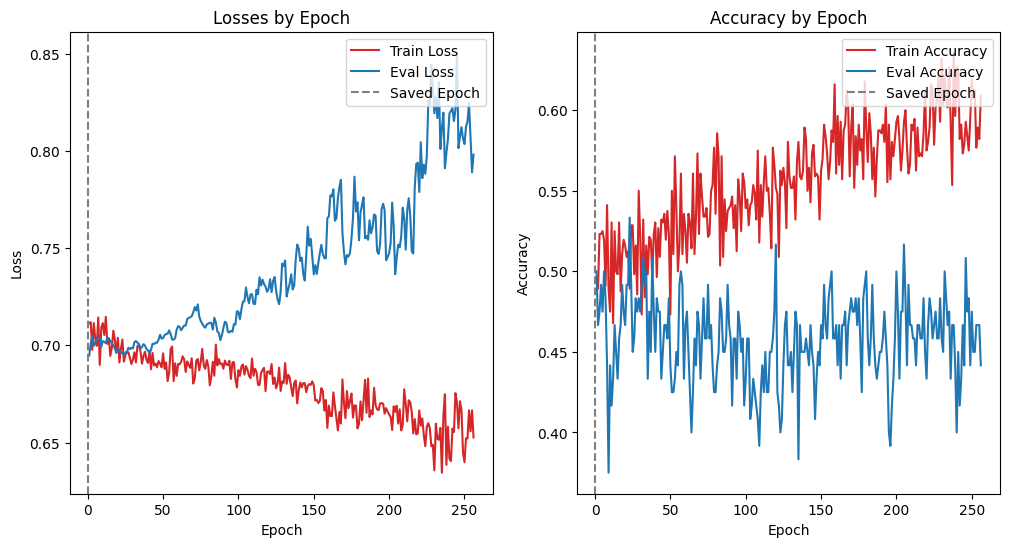

In [131]:
plot_train_eval_loss_accuracy(train_loss=trainer.train_losses,
                              train_accuracy=trainer.train_accuracies,
                              eval_loss=trainer.eval_losses,
                              eval_accuracy=trainer.eval_accuracies,
                              saved_epoch=best_eval_loss_epoch,
                              output_path=plots_dir,
                              output_file=f"model_attacker_pool_{model_id}_train_eval_loss_acc.png")

## Test Model

### Test Model

In [132]:
tester.test()

### Print Metrics

In [133]:
print(f'Test loss: {tester.loss:.4f}')
print(f'Test accuracy: {tester.accuracy_score:.2f}')
print(f'Test precision: {tester.precision_score:.2f}')
print(f'Test recall: {tester.recall_score:.2f}')
print(f'Test f1: {tester.f1_score:.2f}')
print(f'Test AUC: {tester.auroc_score:.2f}')

Test loss: 0.6937
Test accuracy: 0.51
Test precision: 1.00
Test recall: 0.02
Test f1: 0.03
Test AUC: 0.51


### Plot ROC Curve

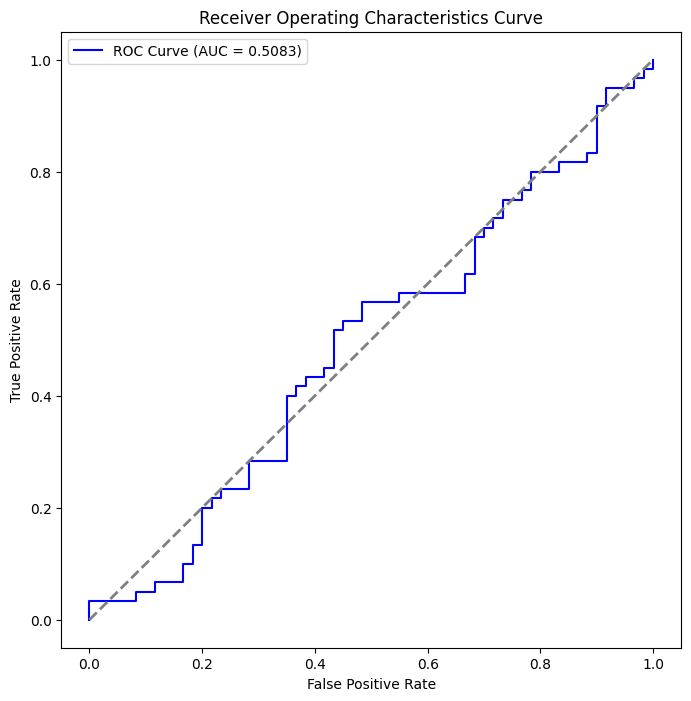

In [134]:
fpr, tpr, _ = tester.roc_curve
plot_receiver_operating_characteristics_curve(false_positive_rates=fpr,
                                              true_positive_rates=tpr,
                                              auc=tester.auroc_score,
                                              output_path=plots_dir,
                                              output_file=f"model_attacker_pool_{model_id}_roc_curve.png")

### Plot Confusion Matrix

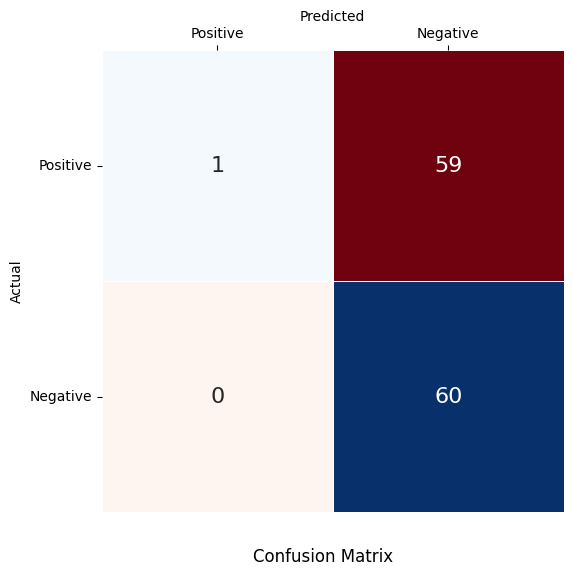

In [135]:
plot_confusion_matrix(confusion_matrix=tester.confusion_matrix_scores,
                      task="binary",
                      output_path=plots_dir,
                      output_file=f"model_attacker_pool_{model_id}_confusion_matrix.png")

## Save Model


In [136]:
manager.add_model(
    model_id=model_id,
    random_seed=random_seed,
    data=dataset,
    loader=loader_train,
    model=model,
    trainer=trainer,
    tester=tester
)